Running direct simulation...


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 258.07it/s]


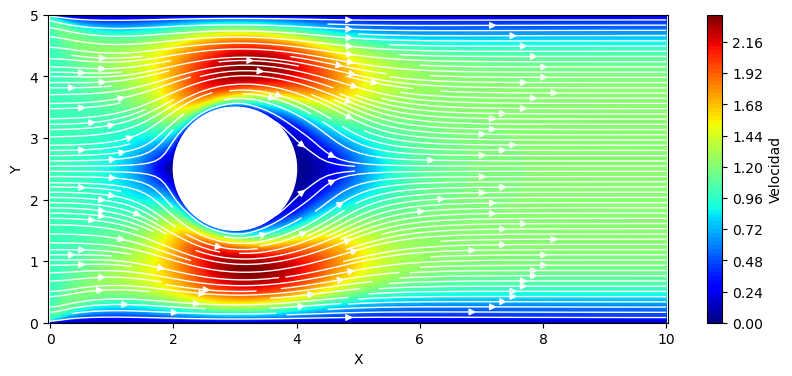

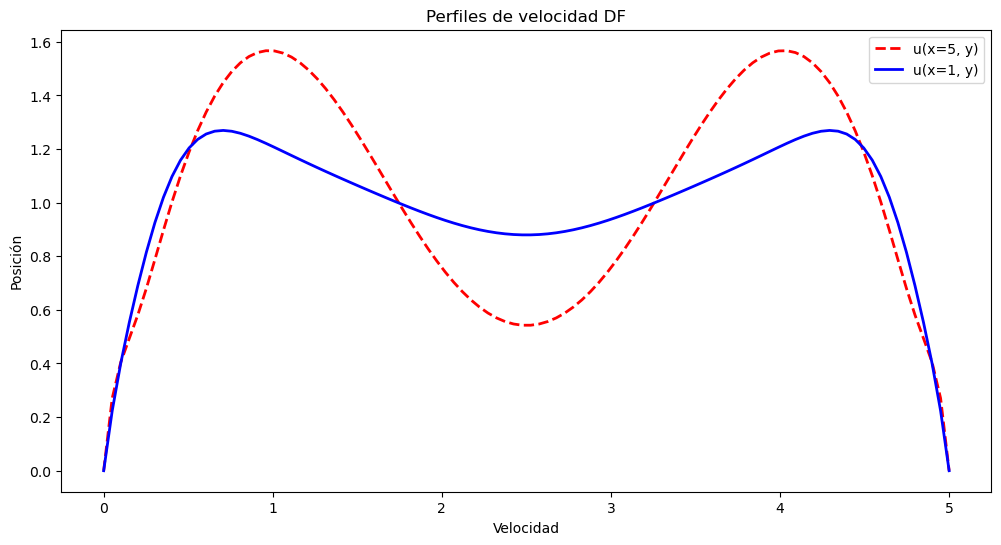

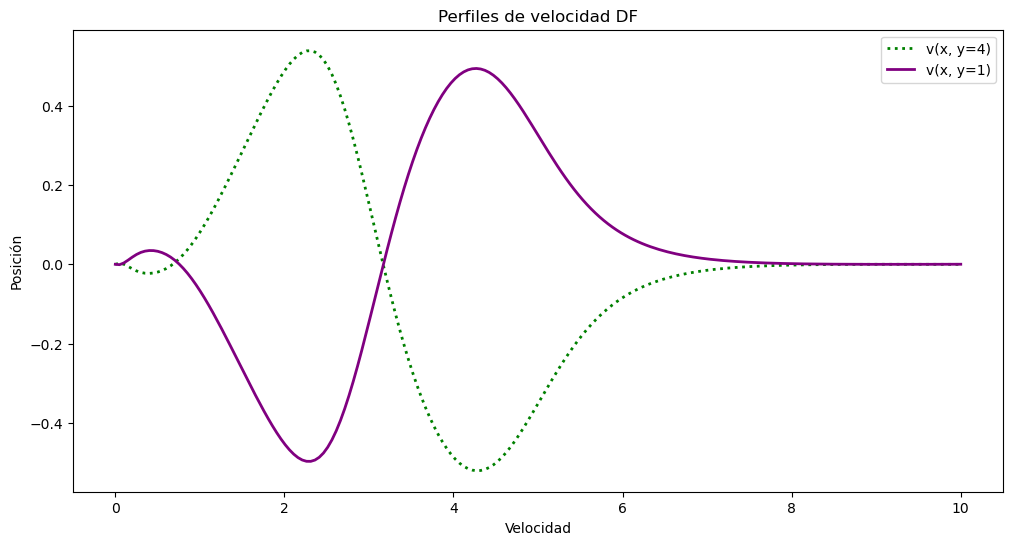

In [2]:
"""
Simulación Numérica de Flujo alrededor de un Cilindro

Este código implementa una simulación numérica del flujo de un fluido incompresible
alrededor de un cilindro utilizando el método de diferencias finitas. Se resuelven
las ecuaciones de Navier-Stokes mediante un esquema de proyección temporal.

Características principales:
- Resuelve las ecuaciones de Navier-Stokes para flujo incompresible
- Utiliza el método de diferencias finitas para discretización espacial
- Implementa un esquema de proyección para el acoplamiento presión-velocidad
- Incluye un cilindro como obstáculo en el flujo
- Genera visualizaciones del campo de flujo y perfiles de velocidad
- Guarda resultados en archivos para post-procesamiento

"""

# Importación de bibliotecas necesarias
import numpy as np              # Biblioteca para cálculos numéricos y operaciones con arrays
import matplotlib.pyplot as plt # Biblioteca para crear gráficos y visualizaciones
from tqdm import tqdm          # Biblioteca para mostrar barras de progreso en bucles

# Parámetros de discretización espacial
N_X = 200              # Número de puntos en la dirección X del dominio
N_Y = 100              # Número de puntos en la dirección Y del dominio
L_X = 10.0            # Longitud física del dominio en dirección X
L_Y = 5.0             # Longitud física del dominio en dirección Y

# Parámetros de discretización temporal y simulación
N_ITERATIONS = 1000    # Número total de pasos temporales a simular
TIME_STEP_LENGTH = 0.001  # Tamaño del paso temporal (delta t)

# Propiedades físicas del fluido
KINEMATIC_VISCOSITY = 0.1 # Viscosidad cinemática del fluido (nu)
DENSITY = 1.0             # Densidad del fluido (rho)
U_IN = 1.0               # Velocidad de entrada del fluido en la frontera izquierda

# Parámetros geométricos del cilindro
CYLINDER_RADIUS = 1      # Radio del cilindro obstáculo
CYLINDER_CENTER_X = 3.0  # Coordenada X del centro del cilindro
CYLINDER_CENTER_Y = 2.5  # Coordenada Y del centro del cilindro

# Parámetros numéricos
N_PRESSURE_POISSON_ITERATIONS = 50  # Número de iteraciones para resolver la ecuación de Poisson
STABILITY_SAFETY_FACTOR = 0.5       # Factor de seguridad para el criterio de estabilidad

def main():
    """Función principal que ejecuta la simulación completa"""
    
    # Cálculo de los espaciados de la malla
    dx = L_X / (N_X - 1)     # Espaciado entre puntos en dirección X
    dy = L_Y / (N_Y - 1)     # Espaciado entre puntos en dirección Y
    
    # Creación de las coordenadas de la malla
    x = np.linspace(0.0, L_X, N_X)  # Array de coordenadas X
    y = np.linspace(0.0, L_Y, N_Y)  # Array de coordenadas Y
    X, Y = np.meshgrid(x, y)         # Creación de la malla 2D
    
    def create_cylinder_mask(X, Y):
        """
        Crea una máscara booleana para identificar los puntos dentro del cilindro
        
        Args:
            X, Y: Arrays 2D con las coordenadas de cada punto de la malla
            
        Returns:
            Array booleano donde True indica puntos dentro del cilindro
        """
        return (X - CYLINDER_CENTER_X)**2 + (Y - CYLINDER_CENTER_Y)**2 <= CYLINDER_RADIUS**2    
    
    # Crear la máscara del cilindro
    cylinder_mask = create_cylinder_mask(X, Y)  # True para puntos dentro del cilindro

    # Inicialización de los campos de velocidad y presión
    u = np.zeros_like(X)  # Campo de velocidad en dirección X
    v = np.zeros_like(X)  # Campo de velocidad en dirección Y
    p = np.zeros_like(X)  # Campo de presión
    
    # Establecer condición inicial de velocidad en la entrada
    u[:, 0] = U_IN       # Velocidad uniforme en la entrada (borde izquierdo)
    
    # Aplicar condición de no deslizamiento en el cilindro
    u[cylinder_mask] = 0.0  # Velocidad X nula en el cilindro
    v[cylinder_mask] = 0.0  # Velocidad Y nula en el cilindro

    def central_difference_x(f):
        """
        Calcula la derivada parcial respecto a x usando diferencias centrales
        
        Args:
            f: Array 2D con la función a derivar
            
        Returns:
            Array 2D con la derivada parcial respecto a x
        """
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, 0:-2]) / (2 * dx)
        return diff
    
    def central_difference_y(f):
        """
        Calcula la derivada parcial respecto a y usando diferencias centrales
        
        Args:
            f: Array 2D con la función a derivar
            
        Returns:
            Array 2D con la derivada parcial respecto a y
        """
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[2:, 1:-1] - f[0:-2, 1:-1]) / (2 * dy)
        return diff
    
    def laplace(f):
        """
        Calcula el operador laplaciano discreto de una función
        
        Args:
            f: Array 2D con la función a la que calcular el laplaciano
            
        Returns:
            Array 2D con el laplaciano discreto
        """
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 0:-2] + f[0:-2, 1:-1] - 4 * f[1:-1, 1:-1] + 
            f[1:-1, 2:] + f[2:, 1:-1]
        ) / (dx * dy)
        return diff

    # Verificación del criterio de estabilidad numérica
    max_time_step = 0.5 * min(dx, dy)**2 / KINEMATIC_VISCOSITY
    if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * max_time_step:
        raise RuntimeError("Stability is not guaranteed")

    # Arrays para almacenar la historia temporal de los campos
    u_history = []  # Almacena la evolución del campo de velocidad X
    v_history = []  # Almacena la evolución del campo de velocidad Y
    p_history = []  # Almacena la evolución del campo de presión
    
    print("Running direct simulation...")

    # Bucle principal de la simulación temporal
    for iter in tqdm(range(N_ITERATIONS)):
        # Cálculo de todas las derivadas espaciales necesarias
        du_dx = central_difference_x(u)  # ∂u/∂x
        du_dy = central_difference_y(u)  # ∂u/∂y
        dv_dx = central_difference_x(v)  # ∂v/∂x
        dv_dy = central_difference_y(v)  # ∂v/∂y
        laplace_u = laplace(u)  # ∇²u
        laplace_v = laplace(v)  # ∇²v

        # Cálculo de velocidades tentativas (paso predictor)
        u_tent = (
            u + TIME_STEP_LENGTH * (
                -(u * du_dx + v * du_dy) +         # Términos convectivos
                KINEMATIC_VISCOSITY * laplace_u    # Términos viscosos
            )
        )
        v_tent = (
            v + TIME_STEP_LENGTH * (
                -(u * dv_dx + v * dv_dy) +         # Términos convectivos
                KINEMATIC_VISCOSITY * laplace_v    # Términos viscosos
            )
        )

        # Aplicación de condiciones de contorno a velocidades tentativas
        u_tent[:, 0] = U_IN   # Velocidad de entrada
        v_tent[:, 0] = 0.0    # Componente vertical nula en entrada

        u_tent[:, -1] = u_tent[:, -2]  # Gradiente nulo en salida
        v_tent[:, -1] = v_tent[:, -2]  # Gradiente nulo en salida

        # Condiciones de no deslizamiento en paredes superior e inferior
        u_tent[0, :] = 0.0    # Velocidad nula en pared inferior
        v_tent[0, :] = 0.0
        u_tent[-1, :] = 0.0   # Velocidad nula en pared superior
        v_tent[-1, :] = 0.0
        
        # Condiciones de no deslizamiento en el cilindro
        u_tent[cylinder_mask] = 0.0
        v_tent[cylinder_mask] = 0.0

        # Cálculo de la divergencia del campo de velocidades tentativo
        div_u = central_difference_x(u_tent) + central_difference_y(v_tent)
        rhs = DENSITY / TIME_STEP_LENGTH * div_u  # Término fuente ecuación Poisson

        # Resolución iterativa de la ecuación de Poisson para la presión
        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            p_new = np.zeros_like(p)
            # Aplicación del método de Gauss-Seidel
            p_new[1:-1, 1:-1] = 0.25 * (
                p[1:-1, 0:-2] + p[0:-2, 1:-1] + 
                p[1:-1, 2:] + p[2:, 1:-1] - 
                dx * dy * rhs[1:-1, 1:-1]
            )
            
            # Condiciones de contorno para la presión
            p_new[:, 0] = p_new[:, 1]     # Gradiente nulo en entrada
            p_new[:, -1] = 0.0            # Presión nula en salida (referencia)
            p_new[0, :] = p_new[1, :]     # Gradiente nulo en pared inferior
            p_new[-1, :] = p_new[-2, :]   # Gradiente nulo en pared superior
            p_new[cylinder_mask] = p_new[cylinder_mask]  # Mantener presión en cilindro
            
            p = p_new  # Actualizar campo de presión

        # Cálculo del gradiente de presión
        dp_dx = central_difference_x(p)  # ∂p/∂x
        dp_dy = central_difference_y(p)  # ∂p/∂y
        
        # Corrección de velocidades (paso corrector)
        u_new = u_tent - TIME_STEP_LENGTH / DENSITY * dp_dx
        v_new = v_tent - TIME_STEP_LENGTH / DENSITY * dp_dy

        # Aplicación final de todas las condiciones de contorno
        u_new[:, 0] = U_IN    # Velocidad de entrada
        v_new[:, 0] = 0.0     # Componente vertical nula en entrada

        u_new[:, -1] = u_new[:, -2]  # Gradiente nulo en salida
        v_new[:, -1] = v_new[:, -2]

        # No deslizamiento en paredes
        u_new[0, :] = 0.0     # Pared inferior
        v_new[0, :] = 0.0
        u_new[-1, :] = 0.0    # Pared superior
        v_new[-1, :] = 0.0
        
        # No deslizamiento en cilindro
        u_new[cylinder_mask] = 0.0
        v_new[cylinder_mask] = 0.0

        # Actualización de los campos de velocidad
        u = u_new
        v = v_new
        
        # Guardado de la historia temporal cada 1000 pasos
        if iter % 1000 == 0:
            u_history.append(u.copy())
            v_history.append(v.copy())
            p_history.append(p.copy())

    # Guardado de resultados finales en archivos
    np.savetxt('u_DF_FO.dat', u[:, :], fmt='%.6f')      # Campo de velocidad X
    np.savetxt('v_DF_FO.dat', v[:, :], fmt='%.6f')      # Campo de velocidad Y
    np.savetxt('X_coords.dat', X.flatten(), fmt='%.6f')  # Coordenadas X de la malla
    np.savetxt('Y_coords.dat', Y.flatten(), fmt='%.6f')  # Coordenadas Y de la malla
    
    # Guardado de perfiles de velocidad específicos
    np.savetxt('u_x5_y_DF_FO.dat', u[:, int(5/dx)], fmt='%.6f')  # Perfil U en x=5
    np.savetxt('u_x1_y_DF_FO.dat', u[:, int(1/dx)], fmt='%.6f')  # Perfil U en x=1
    np.savetxt('v_x_y4_DF_FO.dat', v[int(4/dy), :], fmt='%.6f')  # Perfil V en y=4
    np.savetxt('v_x_y1_DF_FO.dat', v[int(1/dy), :], fmt='%.6f')  # Perfil V en y=1

    # Configuración del estilo de visualización
    plt.style.use("default")
    
    # Cálculo de la magnitud de la velocidad
    velocity_magnitude = np.sqrt(u**2 + v**2)
    
    # Creación del primer gráfico: campo de velocidades
    plt.figure(figsize=(10, 4))
    # Graficar contorno de velocidades
    plt.contourf(X, Y, velocity_magnitude, levels=90, cmap='jet')
    plt.colorbar(label='Velocidad')
    
    # Añadir representación del cilindro
    circle = plt.Circle((CYLINDER_CENTER_X, CYLINDER_CENTER_Y), 
                       CYLINDER_RADIUS, color='white', fill=True)
    plt.gca().add_patch(circle)
    
    # Añadir líneas de corriente al gráfico
    plt.streamplot(X, Y, u, v, color='white', linewidth=1, density=2)  # Visualiza las líneas de flujo
    plt.xlabel('X')  # Etiqueta del eje X
    plt.ylabel('Y')  # Etiqueta del eje Y
    plt.axis('equal')  # Mantiene la proporción 1:1 en los ejes
    plt.savefig('flow_visualization_DF.png')  # Guarda la visualización en un archivo

    # Creación del segundo gráfico: perfiles de velocidad U
    plt.figure(figsize=(12, 6))  # Crea una nueva figura con tamaño específico
    # Grafica el perfil de velocidad U en x=5
    plt.plot(y, u[:, int(5/dx)], color='red', linestyle='--', 
            linewidth=2, label='u(x=5, y)')
    # Grafica el perfil de velocidad U en x=1
    plt.plot(y, u[:, int(1/dx)], color='blue', linestyle='-', 
            linewidth=2, label='u(x=1, y)')
    plt.xlabel('Velocidad')  # Etiqueta del eje X
    plt.ylabel('Posición')   # Etiqueta del eje Y
    plt.title('Perfiles de velocidad DF')  # Título del gráfico
    plt.legend()  # Muestra la leyenda con las etiquetas
    plt.savefig('U_flow_profiles_DF.png')  # Guarda el gráfico en un archivo

    # Creación del tercer gráfico: perfiles de velocidad V
    plt.figure(figsize=(12, 6))  # Crea una nueva figura con tamaño específico
    # Grafica el perfil de velocidad V en y=4
    plt.plot(x, v[int(4/dy), :], color='green', linestyle=':', 
            linewidth=2, label='v(x, y=4)')
    # Grafica el perfil de velocidad V en y=1
    plt.plot(x, v[int(1/dy), :], color='purple', linestyle='-', 
            linewidth=2, label='v(x, y=1)')
    plt.ylabel('Posición')   # Etiqueta del eje Y
    plt.xlabel('Velocidad')  # Etiqueta del eje X
    plt.title('Perfiles de velocidad DF')  # Título del gráfico
    plt.legend()  # Muestra la leyenda con las etiquetas
    plt.savefig('V_flow_profiles_DF.png')  # Guarda el gráfico en un archivo

    # Muestra todos los gráficos generados
    plt.show()

# Punto de entrada del programa
if __name__ == "__main__":
    main()  # Ejecuta la función principal cuando se corre el script directamente

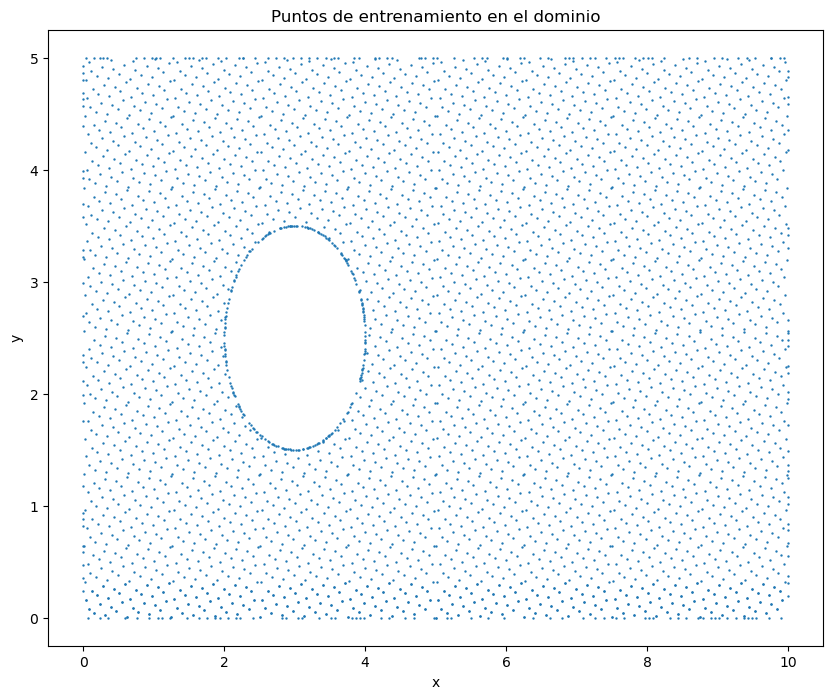

Compiling model...
Building feed-forward neural network...
'build' took 0.033550 s

'compile' took 0.515638 s

Training model...

0         [1.46e-02, 4.86e-03, 3.18e-02, 3.50e+00, 6.25e-02, 5.97e-03, 6.07e-01, 8.76e-02, 2.17e-01, 5.80e-03]                        [1.37e-02, 4.88e-03, 2.99e-02, 3.50e+00, 6.25e-02, 5.97e-03, 6.07e-01, 8.76e-02, 2.17e-01, 5.80e-03]                        []  


KeyboardInterrupt: 

In [4]:
"""
Simulación de Flujo mediante Deep Learning (PINN - Physics-Informed Neural Networks)

Este código implementa una solución de las ecuaciones de Navier-Stokes para el flujo
alrededor de un cilindro utilizando redes neuronales físicamente informadas (PINN).
El modelo aprende a resolver las ecuaciones diferenciales parciales respetando 
las leyes físicas y las condiciones de contorno del problema.

Características principales:
- Utiliza DeepXDE para implementar PINN
- Resuelve las ecuaciones de Navier-Stokes en 2D
- Incluye geometría compleja con un cilindro
- Genera visualizaciones del campo de flujo
- Compara resultados con solución por diferencias finitas

Autor: Leonardo Córdova
Fecha: 09.12.2024
"""

# Importación de bibliotecas necesarias
import numpy as np              # Para cálculos numéricos y operaciones con arrays
import tensorflow as tf         # Framework de deep learning
import matplotlib.pyplot as plt # Para visualización de resultados
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Para ajustar barras de color
import deepxde as dde          # Biblioteca para PINN

# Parámetros físicos y geométricos de la simulación
N_X = 200              # Número de puntos en dirección X
N_Y = 100              # Número de puntos en dirección Y
L_X = 10.0            # Longitud del dominio en X
L_Y = 5.0             # Longitud del dominio en Y
U_IN = 1.0            # Velocidad de entrada del flujo
KINEMATIC_VISCOSITY = 0.1  # Viscosidad cinemática del fluido
DENSITY = 1.0         # Densidad del fluido

# Parámetros del cilindro
CYLINDER_RADIUS = 1.0     # Radio del cilindro
CYLINDER_CENTER_X = 3.0   # Posición X del centro del cilindro
CYLINDER_CENTER_Y = 2.5   # Posición Y del centro del cilindro

# Definición de la geometría del dominio
geom = dde.geometry.Rectangle([0, 0], [L_X, L_Y])  # Dominio rectangular base
cylinder = dde.geometry.Disk([CYLINDER_CENTER_X, CYLINDER_CENTER_Y], CYLINDER_RADIUS)  # Cilindro
geom_with_cylinder = dde.geometry.CSGDifference(geom, cylinder)  # Dominio final (rectángulo - cilindro)

# Funciones para identificar las diferentes fronteras del dominio
def boundary_left(x, on_boundary):
    """Identifica los puntos en la frontera izquierda (entrada)"""
    return on_boundary and np.isclose(x[0], 0)

def boundary_outflow(x, on_boundary):
    """Identifica los puntos en la frontera derecha (salida)"""
    return on_boundary and np.isclose(x[0], L_X)

def boundary_wall(x, on_boundary):
    """Identifica los puntos en las paredes superior e inferior"""
    return on_boundary and (np.isclose(x[1], 0) or np.isclose(x[1], L_Y))

def boundary_cylinder(x, on_boundary):
    """Identifica los puntos en la superficie del cilindro"""
    return on_boundary and cylinder.on_boundary(x)

# Definición de las condiciones de contorno
# Velocidad de entrada (perfil uniforme)
bc_inflow_u = dde.DirichletBC(geom_with_cylinder, lambda x: U_IN, boundary_left, component=0)
bc_inflow_v = dde.DirichletBC(geom_with_cylinder, lambda x: 0, boundary_left, component=1)

# Condición de salida (gradiente nulo)
bc_outflow = dde.NeumannBC(geom_with_cylinder, lambda x: 0, boundary_outflow)

# Condiciones de no deslizamiento en paredes y cilindro
bc_wall_u = dde.DirichletBC(geom_with_cylinder, lambda x: 0, boundary_wall, component=0)
bc_wall_v = dde.DirichletBC(geom_with_cylinder, lambda x: 0, boundary_wall, component=1)
bc_cylinder_u = dde.DirichletBC(geom_with_cylinder, lambda x: 0, boundary_cylinder, component=0)
bc_cylinder_v = dde.DirichletBC(geom_with_cylinder, lambda x: 0, boundary_cylinder, component=1)

def pde(x, y):
    """
    Define las ecuaciones de Navier-Stokes para el flujo incompresible
    
    Args:
        x: Coordenadas espaciales
        y: Variables del flujo [u, v, p]
    
    Returns:
        Lista con las ecuaciones de momento y continuidad
    """
    # Extraer componentes de velocidad y presión
    u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    # Cálculo de derivadas primeras
    du_x = dde.grad.jacobian(y, x, i=0, j=0)  # ∂u/∂x
    du_y = dde.grad.jacobian(y, x, i=0, j=1)  # ∂u/∂y
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)  # ∂v/∂x
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)  # ∂v/∂y
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)  # ∂p/∂x
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)  # ∂p/∂y
    
    # Cálculo de derivadas segundas
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)  # ∂²u/∂x²
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)  # ∂²u/∂y²
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)  # ∂²v/∂x²
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)  # ∂²v/∂y²
    
    # Ecuaciones de Navier-Stokes
    momentum_x = u * du_x + v * du_y + dp_x - KINEMATIC_VISCOSITY * (du_xx + du_yy)
    momentum_y = u * dv_x + v * dv_y + dp_y - KINEMATIC_VISCOSITY * (dv_xx + dv_yy)
    continuity = du_x + dv_y
    
    return [momentum_x, momentum_y, continuity]

# Configuración del problema
data = dde.data.PDE(
    geom_with_cylinder,  # Geometría del problema
    pde,                 # Ecuaciones a resolver
    [bc_inflow_u, bc_inflow_v, bc_outflow, bc_wall_u, bc_wall_v, 
     bc_cylinder_u, bc_cylinder_v],  # Condiciones de contorno
    num_domain=4000,     # Puntos de entrenamiento en el dominio
    num_boundary=400,    # Puntos de entrenamiento en las fronteras
    num_test=200         # Puntos de prueba
)

# Definición de la arquitectura de la red neuronal
layers = [2] + [200] * 3 + [3]  # 2 entradas, 3 capas ocultas de 200 neuronas, 3 salidas
activation = "tanh"             # Función de activación
initializer = "Glorot uniform"  # Inicialización de pesos
net = dde.maps.FNN(layers, activation, initializer)

# Crear y compilar el modelo
model = dde.Model(data, net)

# Visualizar puntos de entrenamiento
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Puntos de entrenamiento en el dominio")
plt.show()

# Entrenar el modelo
model.compile("adam", lr=1e-3)  # Optimizador Adam con learning rate 0.001
losshistory, train_state = model.train(iterations=30000)

# Crear malla para predicciones
n_points_X = 200  # Puntos para visualización en X
n_points = 100    # Puntos para visualización en Y
x = np.linspace(0, L_X, n_points_X)
y = np.linspace(0, L_Y, n_points)
X, Y = np.meshgrid(x, y)
points = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# Realizar predicciones
predictions = model.predict(points)
u = predictions[:, 0].reshape(X.shape)  # Velocidad U
v = predictions[:, 1].reshape(X.shape)  # Velocidad V
p = predictions[:, 2].reshape(X.shape)  # Presión
speed = np.sqrt(u**2 + v**2)           # Magnitud de velocidad

# Guardar perfiles de velocidad
np.savetxt('u_x5_y_DL_FO.dat', u[:, int(5/L_X*n_points_X)], fmt='%.6f')  # Perfil U en x=5
np.savetxt('u_x1_y_DL_FO.dat', u[:, int(1/L_X*n_points_X)], fmt='%.6f')  # Perfil U en x=1
np.savetxt('v_x_y4_DL_FO.dat', v[int(4/L_Y*n_points), :], fmt='%.6f')    # Perfil V en y=4
np.savetxt('v_x_y1_DL_FO.dat', v[int(1/L_Y*n_points), :], fmt='%.6f')    # Perfil V en y=1

# Visualización de resultados
plt.style.use("default")

# Gráfico del campo de velocidades
plt.figure(figsize=(9, 4))
levels = np.linspace(0, 2.4, 100)  # Niveles para el contorno
plt.contourf(X, Y, speed, levels=levels, cmap='jet', vmin=0, vmax=2.4)

# Configurar barra de color
colorbar = plt.colorbar(label='Velocidad')
colorbar.set_ticks(np.linspace(0, 2.4, 11))
colorbar.set_ticklabels([f"{tick:.2f}" for tick in np.linspace(0, 2.4, 11)])

# Añadir cilindro al gráfico
circle = plt.Circle((CYLINDER_CENTER_X, CYLINDER_CENTER_Y), CYLINDER_RADIUS, 
                   color='white', fill=True)
plt.gca().add_patch(circle)

# Añadir líneas de corriente
plt.streamplot(X, Y, u, v, color='white', linewidth=1, density=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.savefig('deep_learning_flow_visualization.png')

# Gráfico de perfiles de velocidad U
plt.figure(figsize=(12, 6))
plt.plot(y, u[:, int(5/L_X*n_points_X)], color='red', linestyle='--', 
         linewidth=2, label='u(x=5, y)')
plt.plot(y, u[:, int(1/L_X*n_points_X)], color='blue', linestyle='-', 
         linewidth=2, label='u(x=1, y)')
plt.xlabel('Velocidad')
plt.ylabel('Posición')
plt.title('Perfiles de velocidad (Finite difference)')
plt.legend()
plt.savefig('U_deep_learning_flow_profiles.png')

# Gráfico de perfiles de velocidad V
plt.figure(figsize=(12, 6))
plt.plot(x, v[int(4/L_Y*n_points), :], color='green', linestyle=':', 
         linewidth=2, label='v(x, y=4)')
plt.plot(x, v[int(1/L_Y*n_points), :], color='purple', linestyle='-', 
         linewidth=2, label='v(x, y=1)')
plt.xlabel('Velocidad')
plt.ylabel('Posición')
plt.title('Perfiles de velocidad (Finite difference)')
plt.legend()
plt.savefig('V_deep_learning_flow_profiles.png')

# Cargar datos para comparación
U1 = np.loadtxt('u_x5_y_DL_FO.dat')    # Perfil U en x=5 (Deep Learning)
U2 = np.loadtxt('u_x1_y_DL_FO.dat')    # Perfil U en x=1 (Deep Learning)
U3 = np.loadtxt('v_x_y4_DL_FO.dat')    # Perfil V en y=4 (Deep Learning)
U4 = np.loadtxt('v_x_y1_DL_FO.dat')    # Perfil V en y=1 (Deep Learning)
U5 = np.loadtxt('u_x5_y_DF_FO.dat')    # Perfil U en x=5 (Diferencias Finitas)
U6 = np.loadtxt('u_x1_y_DF_FO.dat')    # Perfil U en x=1 (Diferencias Finitas)
U7 = np.loadtxt('v_x_y4_DF_FO.dat')    # Perfil V en y=4 (Diferencias Finitas)
U8 = np.loadtxt('v_x_y1_DF_FO.dat')    # Perfil V en y=1 (Diferencias Finitas)

# Mostrar todos los gráficos
plt.show()

In [ ]:
"""
Implementación de Inverse - hysics-Informed Neural Networks (I-PINNs) para Flujo alrededor de un Cilindro

Este código implementa una red neuronal físicamente informada para resolver las ecuaciones
de Navier-Stokes. Los PINNs combinan el aprendizaje supervisado con las restricciones
físicas de las ecuaciones diferenciales parciales que gobiernan el flujo.

Características principales:
- Integra ecuaciones físicas en el proceso de aprendizaje
- Utiliza datos de simulación directa como guía
- Impone condiciones de contorno físicamente relevantes
- Escala las derivadas para mejorar el entrenamiento
"""
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import tensorflow as tf
from tqdm import tqdm

#                                       
# Parámetros de simulación   DIRECTa
N_X = 200  # Puntos en dirección X
N_Y = 100  # Puntos en dirección Y
L_X = 10.0  # Longitud del dominio en X
L_Y = 5.0   # Longitud del dominio en Y
N_ITERATIONS = 1000
TIME_STEP_LENGTH = 0.001
KINEMATIC_VISCOSITY = 0.1
DENSITY = 1.0

U_IN = 1.0  # Velocidad de entrada

CYLINDER_RADIUS = 1

CYLINDER_CENTER_X = 3.0
CYLINDER_CENTER_Y = 2.5

N_PRESSURE_POISSON_ITERATIONS = 50
STABILITY_SAFETY_FACTOR = 0.5

def run_direct_simulation():

    # Crear malla
    dx = L_X / (N_X - 1)
    dy = L_Y / (N_Y - 1)
    x = np.linspace(0.0, L_X, N_X)
    y = np.linspace(0.0, L_Y, N_Y)
    X, Y = np.meshgrid(x, y)
    
    def create_cylinder_mask(X, Y):
        """Crea una máscara para el cilindro"""
        return (X - CYLINDER_CENTER_X)**2 + (Y - CYLINDER_CENTER_Y)**2 <= CYLINDER_RADIUS**2    
    

    # Crear máscara del cilindro
    cylinder_mask = create_cylinder_mask(X, Y)

    # Inicializar campos con condiciones iniciales más apropiadas
    u = np.zeros_like(X)  # Inicializar todo en cero
    v = np.zeros_like(X)
    p = np.zeros_like(X)
    
    # Establecer la condición inicial solo en la entrada (pared izquierda)
    u[:, 0] = U_IN  # Velocidad uniforme en la entrada
    
    # Aplicar condición inicial del cilindro
    u[cylinder_mask] = 0.0
    v[cylinder_mask] = 0.0

    def central_difference_x(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, 0:-2]) / (2 * dx)
        return diff
    
    def central_difference_y(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[2:, 1:-1] - f[0:-2, 1:-1]) / (2 * dy)
        return diff
    
    def laplace(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 0:-2] + f[0:-2, 1:-1] - 4 * f[1:-1, 1:-1] + 
            f[1:-1, 2:] + f[2:, 1:-1]
        ) / (dx * dy)
        return diff


    # Verificar estabilidad
    max_time_step = 0.5 * min(dx, dy)**2 / KINEMATIC_VISCOSITY
    if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * max_time_step:
        raise RuntimeError("Stability is not guaranteed")

    # Para almacenar la historia de la velocidad
    u_history = []
    v_history = []
    p_history = []
    print("Running direct simulation...")

    for iter in tqdm(range(N_ITERATIONS)):
        # Gradientes
        du_dx = central_difference_x(u)
        du_dy = central_difference_y(u)
        dv_dx = central_difference_x(v)
        dv_dy = central_difference_y(v)
        laplace_u = laplace(u)
        laplace_v = laplace(v)

        # Paso tentativo
        u_tent = (
            u + TIME_STEP_LENGTH * (
                -(u * du_dx + v * du_dy) +
                KINEMATIC_VISCOSITY * laplace_u
            )
        )
        v_tent = (
            v + TIME_STEP_LENGTH * (
                -(u * dv_dx + v * dv_dy) +
                KINEMATIC_VISCOSITY * laplace_v
            )
        )

        # Condiciones de frontera para velocidad tentativa
        # Entrada: perfil uniforme
        u_tent[:, 0] = U_IN  # Velocidad uniforme en toda la entrada
        v_tent[:, 0] = 0.0

        # Salida: gradiente cero (du/dx = 0)
        u_tent[:, -1] = u_tent[:, -2]
        v_tent[:, -1] = v_tent[:, -2]

        # Paredes superior e inferior: no deslizamiento
        u_tent[0, :] = 0.0   # Pared inferior
        v_tent[0, :] = 0.0
        u_tent[-1, :] = 0.0  # Pared superior
        v_tent[-1, :] = 0.0
        
        # Aplicar condiciones del cilindro
        u_tent[cylinder_mask] = 0.0
        v_tent[cylinder_mask] = 0.0

        # Resolver ecuación de Poisson para la presión
        div_u = central_difference_x(u_tent) + central_difference_y(v_tent)
        rhs = DENSITY / TIME_STEP_LENGTH * div_u

        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            p_new = np.zeros_like(p)
            p_new[1:-1, 1:-1] = 0.25 * (
                p[1:-1, 0:-2] + p[0:-2, 1:-1] + 
                p[1:-1, 2:] + p[2:, 1:-1] - 
                dx * dy * rhs[1:-1, 1:-1]
            )
            
            # Condiciones de frontera para presión
            p_new[:, 0] = p_new[:, 1]    # Entrada
            p_new[:, -1] = 0.0           # Salida (presión de referencia)
            p_new[0, :] = p_new[1, :]    # Pared inferior
            p_new[-1, :] = p_new[-2, :]  # Pared superior
            
            # Condición de presión en el cilindro
            p_new[cylinder_mask] = p_new[cylinder_mask]
            
            p = p_new

        # Corregir velocidades
        dp_dx = central_difference_x(p)
        dp_dy = central_difference_y(p)
        
        u_new = u_tent - TIME_STEP_LENGTH / DENSITY * dp_dx
        v_new = v_tent - TIME_STEP_LENGTH / DENSITY * dp_dy

        # Aplicar condiciones de frontera finales
        # Entrada: perfil uniforme
        u_new[:, 0] = U_IN  # Velocidad uniforme en toda la entrada
        v_new[:, 0] = 0.0

        # Salida: gradiente cero
        u_new[:, -1] = u_new[:, -2]
        v_new[:, -1] = v_new[:, -2]

        # Paredes: no deslizamiento
        u_new[0, :] = 0.0    # Pared inferior
        v_new[0, :] = 0.0
        u_new[-1, :] = 0.0   # Pared superior
        v_new[-1, :] = 0.0
        
        # Aplicar condiciones del cilindro
        u_new[cylinder_mask] = 0.0
        v_new[cylinder_mask] = 0.0

        # Actualizar campos
        u = u_new
        v = v_new

    return X, Y, u, v
########################################################################################################### 
"""
Entrenamiento y Evaluación de Inverse- Physics-Informed Neural Network (PINN)

Este módulo contiene las funciones para entrenar, evaluar y comparar los resultados
del modelo PINN con la simulación directa. Incluye:
- Generación de datos de entrenamiento con muestreo inteligente
- Entrenamiento multi-etapa del modelo
- Comparación visual y numérica de resultados
- Guardado de resultados para análisis posterior
"""

def create_training_data(u, v, n_samples=10000):
    """Create training data with improved sampling"""
    # Crear malla
    dx = L_X / (N_X - 1)  # Calcular el tamaño de paso en el eje x
    dy = L_Y / (N_Y - 1)  # Calcular el tamaño de paso en el eje y
    x = np.linspace(0.0, L_X, N_X)  # Crear un vector de coordenadas x
    y = np.linspace(0.0, L_Y, N_Y)  # Crear un vector de coordenadas y
    X, Y = np.meshgrid(x, y)  # Crear la malla de coordenadas (X, Y)
    
    # Print debugging information
    print("Shape of u:", u.shape)  # Imprimir la forma del vector u
    print("Shape of v:", v.shape)  # Imprimir la forma del vector v
    print("Shape of X:", X.shape)  # Imprimir la forma de la malla X
    print("Shape of Y:", Y.shape)  # Imprimir la forma de la malla Y

    # Calculate gradients for importance sampling
    du_dx = np.gradient(u, dx, axis=1)  # Calcular el gradiente de u respecto a x
    du_dy = np.gradient(u, dy, axis=0)  # Calcular el gradiente de u respecto a y
    dv_dx = np.gradient(v, dx, axis=1)  # Calcular el gradiente de v respecto a x
    dv_dy = np.gradient(v, dy, axis=0)  # Calcular el gradiente de v respecto a y

    # Calculate importance weights
    importance = np.sqrt(du_dx**2 + du_dy**2 + dv_dx**2 + dv_dy**2)  # Calcular la magnitud del gradiente
    importance = importance / importance.sum()  # Normalizar los pesos de importancia

    # Flatten arrays consistently
    points = np.column_stack((X.flatten(), Y.flatten()))  # Concatenar las coordenadas x e y en una matriz de puntos
    values = np.column_stack((u.flatten(), v.flatten()))  # Concatenar los valores de u y v en una matriz de valores

    # Flatten importance consistently with points and values
    weights = importance.flatten()  # Aplanar el vector de pesos de importancia

    # Normalize weights to ensure they sum to 1 and are non-negative
    weights = np.abs(weights)  # Tomar el valor absoluto de los pesos
    weights = weights / weights.sum()  # Normalizar los pesos para que sumen 1

    # Ensure the length of points equals the length of weights
    assert len(points) == len(weights), f"Length mismatch between points ({len(points)}) and weights ({len(weights)})"

    # Weighted sampling
    idx = np.random.choice(
        len(points), 
        size=min(n_samples, len(points)), 
        replace=False,
        p=weights
    )  # Realizar un muestreo ponderado de los puntos

    train_points = points[idx]  # Seleccionar los puntos de entrenamiento
    train_values = values[idx]  # Seleccionar los valores de entrenamiento

    return train_points, train_values[:, 0], train_values[:, 1]  # Devolver los puntos de entrenamiento, u y v

def create_neural_network(train_points, train_u, train_v):
    """Create an improved neural network architecture"""
    # Define geometry
    # Crear la geometría con el obstáculo circular (cilindro)
    geom = dde.geometry.Rectangle([0, 0], [L_X, L_Y])  # Crear un rectángulo que representa el dominio
    cylinder = dde.geometry.Disk([CYLINDER_CENTER_X, CYLINDER_CENTER_Y], CYLINDER_RADIUS)  # Crear un círculo que representa el cilindro
    geom_with_cylinder = dde.geometry.CSGDifference(geom, cylinder)  # Crear la geometría con el cilindro como obstáculo

    # Condiciones de contorno
    def boundary_left(x, on_boundary):
        return on_boundary and np.isclose(x[0], 0)  # Definir la condición de contorno de la pared izquierda

    def boundary_outflow(x, on_boundary):
        return on_boundary and np.isclose(x[0], L_X)  # Definir la condición de contorno de la salida

    def boundary_wall(x, on_boundary):
        return on_boundary and (np.isclose(x[1], 0) or np.isclose(x[1], L_Y))  # Definir la condición de contorno de las paredes superiores e inferiores

    def boundary_cylinder(x, on_boundary):
        return on_boundary and cylinder.on_boundary(x)  # Definir la condición de contorno del cilindro

    # Velocidad uniforme de entrada en la pared izquierda
    bc_inflow_u = dde.DirichletBC(geom_with_cylinder, lambda x: U_IN, boundary_left, component=0)  # Condición de contorno de entrada para u
    bc_inflow_v = dde.DirichletBC(geom_with_cylinder, lambda x: 0, boundary_left, component=1)  # Condición de contorno de entrada para v

    # Condición de salida: gradiente cero (Neumann)
    bc_outflow = dde.NeumannBC(geom_with_cylinder, lambda x: 0, boundary_outflow)  # Condición de contorno de salida

    # No deslizamiento en el cilindro y en las paredes superior e inferior
    bc_wall_u = dde.DirichletBC(geom_with_cylinder, lambda x: 0, boundary_wall, component=0)  # Condición de contorno de no deslizamiento en las paredes para u
    bc_wall_v = dde.DirichletBC(geom_with_cylinder, lambda x: 0, boundary_wall, component=1)  # Condición de contorno de no deslizamiento en las paredes para v
    bc_cylinder_u = dde.DirichletBC(geom_with_cylinder, lambda x: 0, boundary_cylinder, component=0)  # Condición de contorno de no deslizamiento en el cilindro para u
    bc_cylinder_v = dde.DirichletBC(geom_with_cylinder, lambda x: 0, boundary_cylinder, component=1)  # Condición de contorno de no deslizamiento en el cilindro para v

    # Improved observations with noise handling
    observe_u = dde.PointSetBC(train_points, train_u.reshape(-1, 1), component=0)  # Observaciones de u en los puntos de entrenamiento
    observe_v = dde.PointSetBC(train_points, train_v.reshape(-1, 1), component=1)  # Observaciones de v en los puntos de entrenamiento
    
    def pde(x, y):
        """Enhanced PDE implementation with scaled derivatives"""
        u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]  # Extraer los valores de u, v y p
        
        # Scaled derivatives
        scaleX = 1.0 / L_X  # Factor de escala para las derivadas en x
        scaleY = 1.0 / L_Y  # Factor de escala para las derivadas en y
        
        # First order terms
        du_x = dde.grad.jacobian(y, x, i=0, j=0) * scaleX  # Derivada parcial de u respecto a x
        du_y = dde.grad.jacobian(y, x, i=0, j=1) * scaleY  # Derivada parcial de u respecto a y
        dv_x = dde.grad.jacobian(y, x, i=1, j=0) * scaleX  # Derivada parcial de v respecto a x
        dv_y = dde.grad.jacobian(y, x, i=1, j=1) * scaleY  # Derivada parcial de v respecto a y
        dp_x = dde.grad.jacobian(y, x, i=2, j=0) * scaleX  # Derivada parcial de p respecto a x
        dp_y = dde.grad.jacobian(y, x, i=2, j=1) * scaleY  # Derivada parcial de p respecto a y
        
        # Second order terms
        du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0) * scaleX**2  # Segunda derivada parcial de u respecto a x
        du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1) * scaleY**2  # Segunda derivada parcial de u respecto a y
        dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0) * scaleX**2  # Segunda derivada parcial de v respecto a x
        dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1) * scaleY**2  # Segunda derivada parcial de v respecto a y
        
        # Modified equations with proper scaling
        momentum_x = u * du_x + v * du_y + dp_x - KINEMATIC_VISCOSITY * (du_xx + du_yy)  # Término de cantidad de movimiento en x
        momentum_y = u * dv_x + v * dv_y + dp_y - KINEMATIC_VISCOSITY * (dv_xx + dv_yy)  # Término de cantidad de movimiento en y
        
        continuity = du_x + dv_y  # Ecuación de continuidad

        return [momentum_x, momentum_y, continuity]  # Devolver los términos de la ecuación de Navier-Stokes
    
    data = dde.data.PDE(
        geom_with_cylinder,
        pde,
        [bc_inflow_u, bc_inflow_v, bc_outflow, bc_wall_u, bc_wall_v, bc_cylinder_u, bc_cylinder_v, observe_u, observe_v],
        num_domain=3000,
        num_boundary=400,
        anchors=train_points,
        num_test=500
    )  # Crear el objeto de datos PDE con las condiciones de contorno y observaciones
    
    # Create the network
    layers = [2] + [128] * 4 + [3]  # Definir la arquitectura de la red neuronal (2 entradas, 4 capas ocultas de 128 neuronas, 3 salidas)
    net = dde.maps.FNN(layers, "tanh", "Glorot normal")  # Crear la red neuronal
    
    # Create the model
    model = dde.Model(data, net)  # Crear el modelo combinando los datos y la red neuronal
    
    # Advanced training strategy with corrected loss weights
   # model.compile(
   #     "adam", 
   #     lr=1e-3,
   #     loss_weights=[1, 1, 1, 5, 5, 10, 10],  # Corrected weights for all 7 components
   #     decay=("cosine", 30000, 0.1)
   # )
    model.compile(
        "adam", 
        lr=1e-3,
        loss_weights=[1, 1, 1,  # PDEs: momentum_x, momentum_y, continuity
                     5, 5,      # inflow conditions: u, v
                     3,         # outflow condition
                     5, 5,      # wall conditions: u, v
                     5, 5,      # cylinder conditions: u, v
                     1, 1],     # observations: u, v
        decay=("cosine", 30000, 0.1)
    )  # Compilar el modelo con una estrategia de entrenamiento avanzada y pesos de pérdida corregidos
    
    return model  # Devolver el modelo entrenado

def train_model(model, epochs=30000):
    """Enhanced training procedure"""
    checker = dde.callbacks.ModelCheckpoint(
        "model/model.ckpt", 
        save_better_only=True, 
        period=1000
    )  # Crear un callback para guardar el mejor modelo durante el entrenamiento
    
    # Multi-stage training
    print("Stage 1: Initial training...")
    model.train(epochs=epochs//2, display_every=1000, callbacks=[checker])  # Entrenar el modelo durante la primera etapa
    
    print("Stage 2: Fine-tuning...")
    model.compile("L-BFGS-B")
    model.train()  # Entrenar el modelo durante la segunda etapa de ajuste fino
    
    return model  # Devolver el modelo entrenado



def compare_results(X, Y, u, v, model):
    """
    Compara y visualiza resultados entre simulación directa y predicciones PINN.
    
    Args:
        X, Y: Coordenadas de la malla
        u, v: Campos de velocidad de simulación directa
        model: Modelo PINN entrenado
    """
    print("Comparing results...")

    # Preparación de datos para predicción
    x_flat = X.flatten()
    y_flat = Y.flatten()
    points = np.column_stack((x_flat, y_flat))
    
    # Obtención de predicciones
    predictions = model.predict(points)
    u_pred = predictions[:, 0].reshape(X.shape)  # Velocidad U predicha
    v_pred = predictions[:, 1].reshape(X.shape)  # Velocidad V predicha
    
    # Visualización comparativa
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

    # Añadir cilindro a la visualización
    circle = plt.Circle((CYLINDER_CENTER_X, CYLINDER_CENTER_Y), 
                       CYLINDER_RADIUS, color='white', fill=True)
    plt.gca().add_patch(circle)
    
    # Resultados de simulación directa
    im1 = ax1.contourf(X, Y, u, levels=50, cmap='jet')
    plt.colorbar(im1, ax=ax1)
    ax1.set_title('U velocity (Direct)')
    
    im2 = ax2.contourf(X, Y, v, levels=50, cmap='jet')
    plt.colorbar(im2, ax=ax2)
    ax2.set_title('V velocity (Direct)')
    
    # Resultados de la red neuronal
    im3 = ax3.contourf(X, Y, u_pred, levels=50, cmap='jet')
    plt.colorbar(im3, ax=ax3)
    ax3.set_title('U velocity (Neural Network)')
    
    im4 = ax4.contourf(X, Y, v_pred, levels=50, cmap='jet')
    plt.colorbar(im4, ax=ax4)
    ax4.set_title('V velocity (Neural Network)')
    
    plt.tight_layout()
    plt.show()

    # Extracción de perfiles de velocidad específicos
    # Índices para comparación de perfiles
    index_x_minus5 = np.argmin(np.abs(X[0, :] - (5)))  # Perfil en x=5
    index_x_minus1 = np.argmin(np.abs(X[0, :] - (1)))  # Perfil en x=1
    index_y_minus4 = np.argmin(np.abs(Y[:, 0] - (4)))  # Perfil en y=4
    index_y_minus1 = np.argmin(np.abs(Y[:, 0] - (1)))  # Perfil en y=1
    
    # Comparación de perfiles U
    plt.figure(figsize=(10, 5))
    # Perfiles directos vs predichos en x=5 y x=1
    plt.plot(Y[:, 0], u[:, index_x_minus5], '-', color='blue', 
            label='U(x=5, y) Direct')
    plt.plot(Y[:, 0], u_pred[:, index_x_minus5], '--', color='blue', 
            label='U(x=5, y) Predicted')
    plt.plot(Y[:, 0], u[:, index_x_minus1], '-', color='red', 
            label='U(x=1, y) Direct')
    plt.plot(Y[:, 0], u_pred[:, index_x_minus1], '--', color='red', 
            label='U(x=1, y) Predicted')
    plt.xlabel('y')
    plt.ylabel('U velocity')
    plt.title('Comparison of U velocity profiles')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Comparación de perfiles V
    plt.figure(figsize=(10, 5))
    # Perfiles directos vs predichos en y=4 y y=1
    plt.plot(X[index_y_minus4, :], v[index_y_minus4, :], '-', color='green', 
            label='V(x, y=4) Direct')
    plt.plot(X[index_y_minus4, :], v_pred[index_y_minus4, :], '--', color='green', 
            label='V(x, y=4) Predicted')
    plt.plot(X[index_y_minus1, :], v[index_y_minus1, :], '-', color='purple', 
            label='V(x, y=1) Direct')
    plt.plot(X[index_y_minus1, :], v_pred[index_y_minus1, :], '--', color='purple', 
            label='V(x, y=1) Predicted')
    plt.xlabel('x')
    plt.ylabel('V velocity')
    plt.title('Comparison of V velocity profiles')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_results(X, Y, u, v, trained_model):
    """
    Guarda los resultados de la simulación y el modelo entrenado.
    
    Args:
        X, Y: Coordenadas de la malla
        u, v: Campos de velocidad
        trained_model: Modelo PINN entrenado
    """
    np.save('sim_X.npy', X)          # Coordenadas X
    np.save('sim_Y.npy', Y)          # Coordenadas Y
    np.save('sim_u.npy', u)          # Velocidad U
    np.save('sim_v.npy', v)          # Velocidad V
    trained_model.save('trained_model')  # Modelo entrenado
    
def main():
    """
    Función principal que ejecuta la secuencia completa del proceso híbrido de simulación.
    
    El flujo de ejecución es:
    1. Simulación directa para generar datos de referencia
    2. Preparación de datos de entrenamiento
    3. Creación y entrenamiento del modelo PINN
    4. Comparación y visualización de resultados
    5. Guardado de resultados
    """
    # Paso 1: Ejecutar simulación directa por diferencias finitas
    print("2. Running direct simulation...")
    X, Y, u, v = run_direct_simulation()  # Obtiene campos de velocidad de referencia
    
    # Paso 2: Generar datos de entrenamiento con muestreo inteligente
    print("3. Creating training data...")
    train_points, train_u, train_v = create_training_data(u, v)  # Selecciona puntos relevantes
    
    # Paso 3: Crear arquitectura de red neuronal física
    print("4. Creating neural network...")
    model = create_neural_network(train_points, train_u, train_v)  # Define PINN
    
    # Paso 4: Entrenar el modelo en múltiples etapas
    print("5. Training model...")
    trained_model = train_model(model)  # Entrenamiento Adam + L-BFGS-B
    
    # Paso 5: Evaluar y visualizar resultados
    print("6. Comparing results...")
    compare_results(X, Y, u, v, trained_model)  # Comparación visual
    
    # Paso 6: Guardar todos los resultados para análisis posterior
    save_results(X, Y, u, v, trained_model)  # Almacenamiento de datos y modelo

# Punto de entrada del programa
if __name__ == "__main__":
    """
    Punto de entrada del script. Asegura que el código solo se ejecute
    cuando el script se ejecuta directamente y no cuando se importa como módulo.
    """
    main()  # Ejecuta la secuencia completa del proceso

In [ ]:
"""
Función para cargar y visualizar resultados guardados de la simulación
"""

def load_and_plot():
    """
    Carga los resultados guardados y genera visualizaciones comparativas.
    No requiere el modelo entrenado para las visualizaciones básicas.
    """
    # Cargar datos guardados
    X = np.load('sim_X.npy')
    Y = np.load('sim_Y.npy')
    u = np.load('sim_u.npy')
    v = np.load('sim_v.npy')
    
    # Calcular magnitud de velocidad
    speed = np.sqrt(u**2 + v**2)
    
    # Crear visualización
    plt.figure(figsize=(10, 5))
    plt.contourf(X, Y, speed, levels=50, cmap='jet')
    
    # Añadir cilindro
    #circle = plt.Circle((3.0, 2.5), 1.0, color='white', fill=True)
    #plt.gca().add_patch(circle)
    
    plt.colorbar(label='Velocidad')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Campo de velocidades')
    plt.axis('equal')
    
    # Mostrar gráfico
    plt.show()
    
    # Graficar perfiles de velocidad U
    index_x_5 = np.argmin(np.abs(X[0, :] - 5))
    index_x_1 = np.argmin(np.abs(X[0, :] - 1))
    
    plt.figure(figsize=(10, 5))
    plt.plot(Y[:, 0], u[:, index_x_5], '-', color='blue', label='U(x=5, y)')
    plt.plot(Y[:, 0], u[:, index_x_1], '-', color='red', label='U(x=1, y)')
    plt.xlabel('y')
    plt.ylabel('U velocity')
    plt.title('Perfiles de velocidad U')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Graficar perfiles de velocidad V
    index_y_4 = np.argmin(np.abs(Y[:, 0] - 4))
    index_y_1 = np.argmin(np.abs(Y[:, 0] - 1))
    
    plt.figure(figsize=(10, 5))
    plt.plot(X[index_y_4, :], v[index_y_4, :], '-', color='green', label='V(x, y=4)')
    plt.plot(X[index_y_1, :], v[index_y_1, :], '-', color='purple', label='V(x, y=1)')
    plt.xlabel('x')
    plt.ylabel('V velocity')
    plt.title('Perfiles de velocidad V')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejecutar la función
if __name__ == "__main__":
    load_and_plot()